In [6]:
import glob

from lsst import afw
print(afw.version.__version__)
from lsst.daf.persistence import Butler
from lsst.eotest.sensor import MaskedCCD, makeAmplifierGeometry
import numpy

from exploreRun import exploreRun
from lsst.eo_utils.base.image_utils import get_ccd_from_id,\
    get_amp_list, get_data_as_read, sort_sflats

from lsst.eo_utils.base.data_access import get_data_for_run

import lsst.eotest.image_utils as imutil
import pylab

from astropy.io import fits
from astropy.stats import mad_std
import numpy
%matplotlib inline


19.0.0


Setting up file paths we are looking at

In [7]:
superbiaspath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superbias/RTM-013/RTM-013-10982-S21_superbias_normal.fits"
superdarkpath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superdark/RTM-013/RTM-013-10982-S21_superdark_normal.fits"
qeflatpath = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/*_lambda_flat_*")
qeflatpath.sort()

Construct an array of wavelengths where QE acquistions were made

In [8]:
wls = numpy.array([ get_ccd_from_id(None, aqeflatpath, []).md.md["MONOWL"] for aqeflatpath in qeflatpath ])

Let's use SDSS QE for now. Download the QE from the official page. https://www.sdss.org/instruments/camera/

In [9]:
!wget -O filter_curves.fits https://www.sdss.org/wp-content/uploads/2017/04/filter_curves.fits

--2020-07-05 22:46:30--  https://www.sdss.org/wp-content/uploads/2017/04/filter_curves.fits
Resolving www.sdss.org (www.sdss.org)... 128.220.233.141
Connecting to www.sdss.org (www.sdss.org)|128.220.233.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34560 (34K) [image/fits]
Saving to: ‘filter_curves.fits’

100%[======================================>] 34,560      --.-K/s   in 0.07s   

2020-07-05 22:46:32 (503 KB/s) - ‘filter_curves.fits’ saved [34560/34560]



Text(0.5, 0, 'Angstrom')

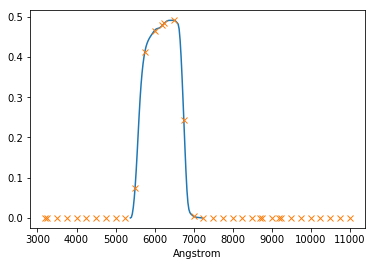

In [10]:
# [('wavelength', '>f4'), ('respt', '>f4'), ('resbig', '>f4'), ('resnoa', '>f4'), ('xatm', '>f4')]
sdssfilter = fits.open("filter_curves.fits")
pylab.plot(sdssfilter[3].data["wavelength"],sdssfilter[3].data["respt"])
weights = numpy.interp(wls*10,sdssfilter[3].data["wavelength"],sdssfilter[3].data["respt"])
pylab.plot(wls*10,weights,"x")
pylab.xlabel("Angstrom")

Sum up QE flats weghted by QE

In [11]:
superdark = get_ccd_from_id(None, superdarkpath, [])
superbias = get_ccd_from_id(None, superbiaspath, [])

arr = []
ch = 1
for i, aqeflatpath in enumerate(qeflatpath):
    aqeflat = get_ccd_from_id(None, aqeflatpath, [], bias_frame=superbias)
    img = aqeflat.unbiased_and_trimmed_image(1).getImage().array
    arr.append(img*weights[i])

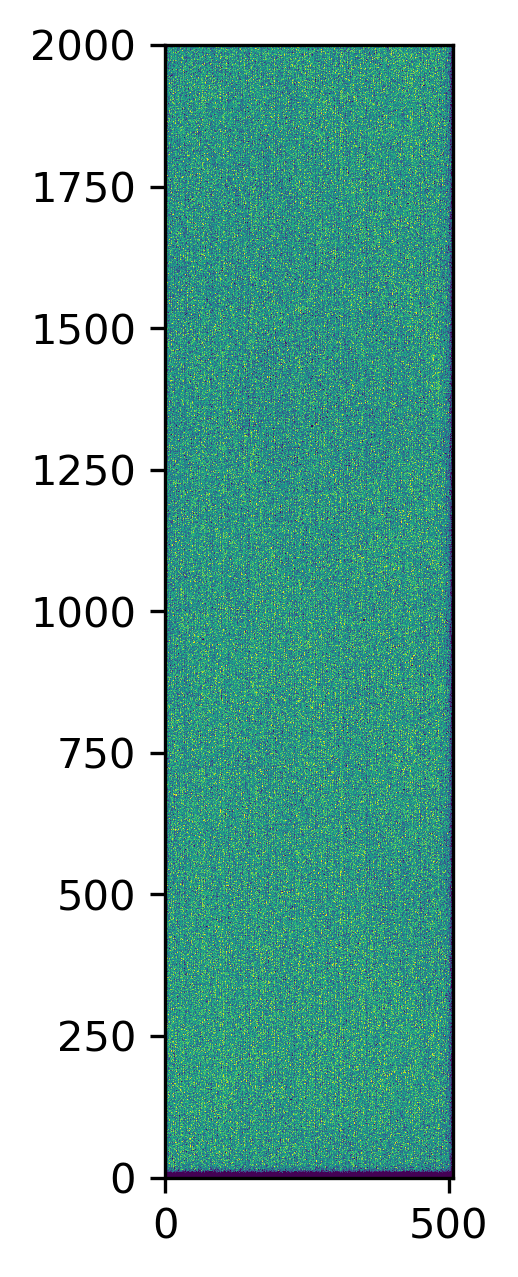

In [12]:
fig, axs = pylab.subplots(figsize=(5,5),dpi=300) 
img = numpy.sum(arr,axis=0)
mean = img.mean()
std = mad_std(img)
N = 3
pylab.imshow(img,vmin=mean-N*std,vmax=mean+N*std,origin="lower")

# Color-color plot

In [13]:
fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_red_-211.815_-0.395.fits"
ccob_red = get_ccd_from_id(None, fname, [])
print ( mad_std(get_data_as_read(ccob_red,ch,["imaging"])["imaging"]))
fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_uv_-211.815_-0.395.fits"
ccob_blue = get_ccd_from_id(None, fname, [])
print ( mad_std(get_data_as_read(ccob_blue,ch,["imaging"])["imaging"]))

# normalize flat 
red = get_data_as_read(ccob_red,ch,["imaging"])["imaging"]

normedimg = img/img.mean()*red.mean()
ratio_red=red / normedimg
ratio_blue=get_data_as_read(ccob_blue,ch,["imaging"])["imaging"] / normedimg

464.05449439225345
431.4372455851302


Making a color-color plot

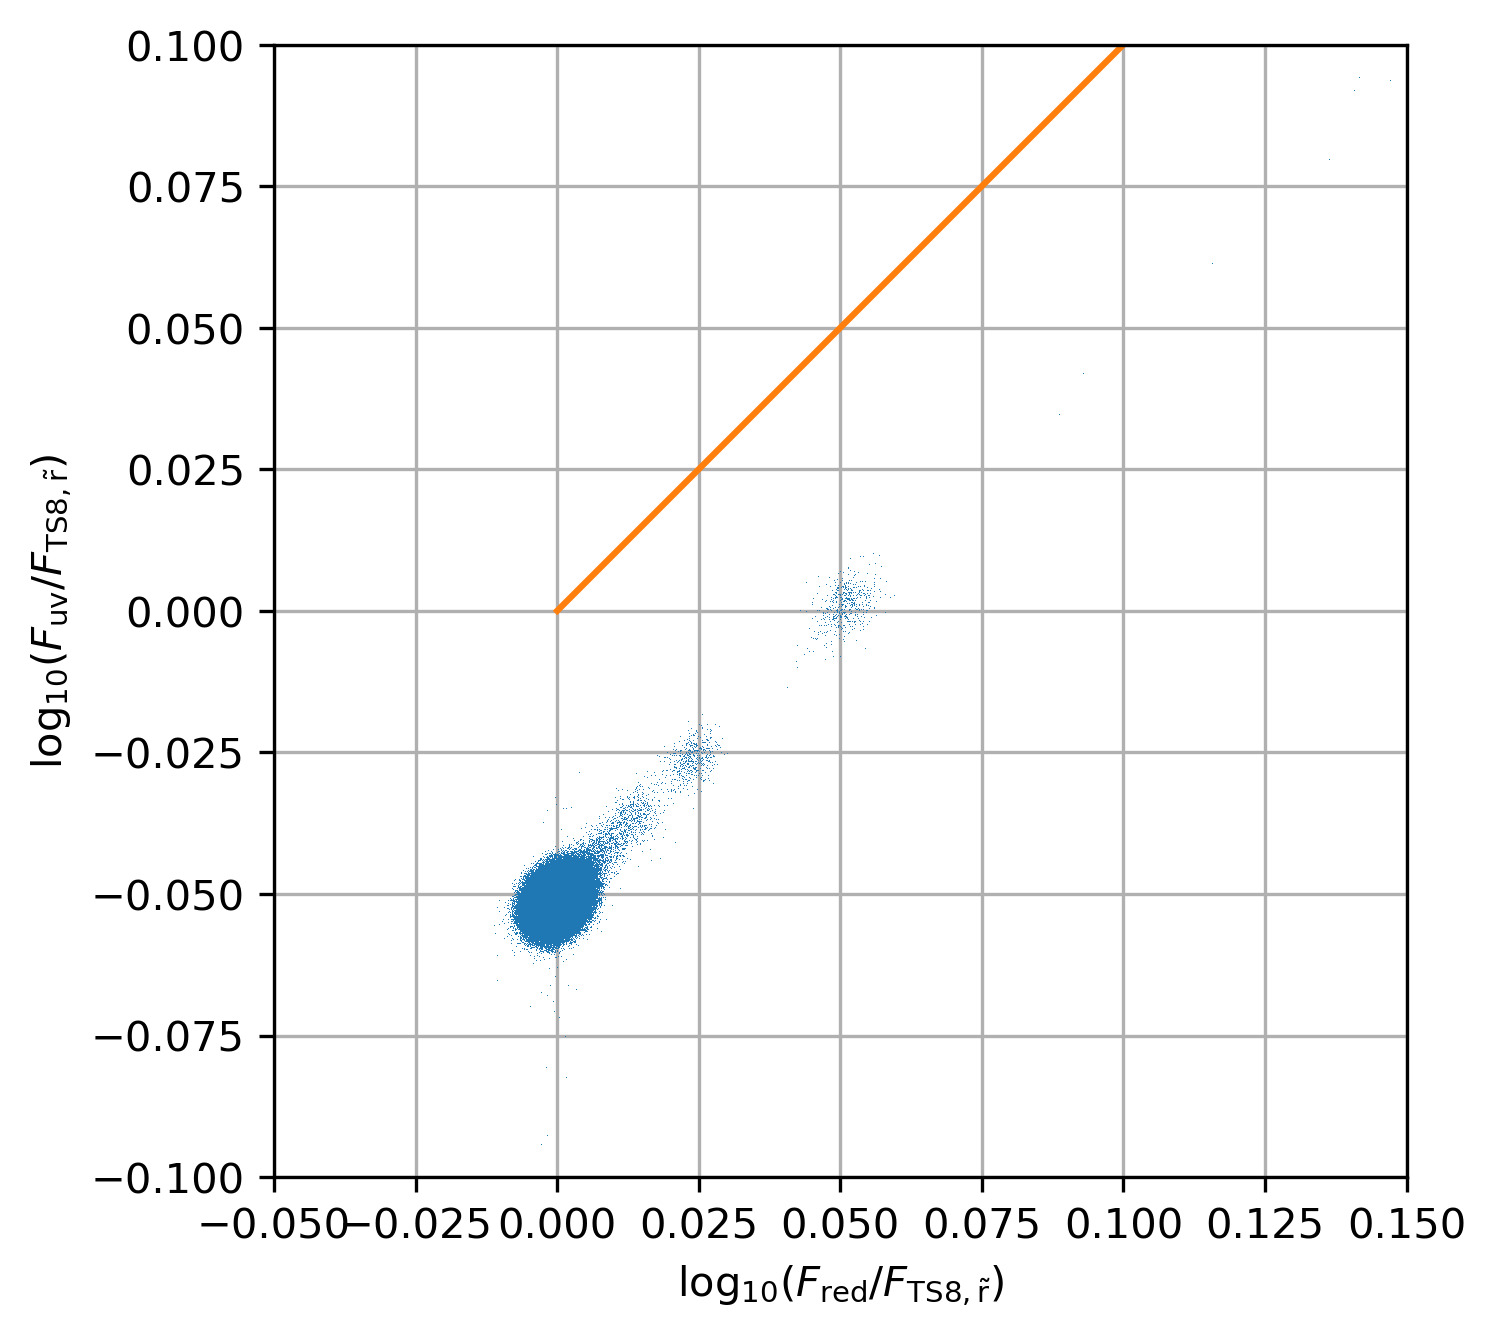

In [14]:
fig, axs = pylab.subplots(1,1,figsize=(5,5),dpi=300) 
pylab.plot(
    numpy.log10(ratio_red.flatten()[::1]),
    numpy.log10(ratio_blue.flatten()[::1]),
    ","
)

x = numpy.arange(0,1,0.1)
pylab.xlabel(r"$\log_{10}(F_{\rm red}/F_{\rm TS8, \tilde{r}})$")
pylab.ylabel(r"$\log_{10}(F_{\rm uv}/F_{\rm TS8, \tilde{r}})$")
pylab.plot(x,x,"-")
pylab.xlim(-0.05,0.15)
pylab.ylim(-0.10,0.10)
pylab.grid()
ax = pylab.gca()
ax.set_aspect(1)

# Direct comparison

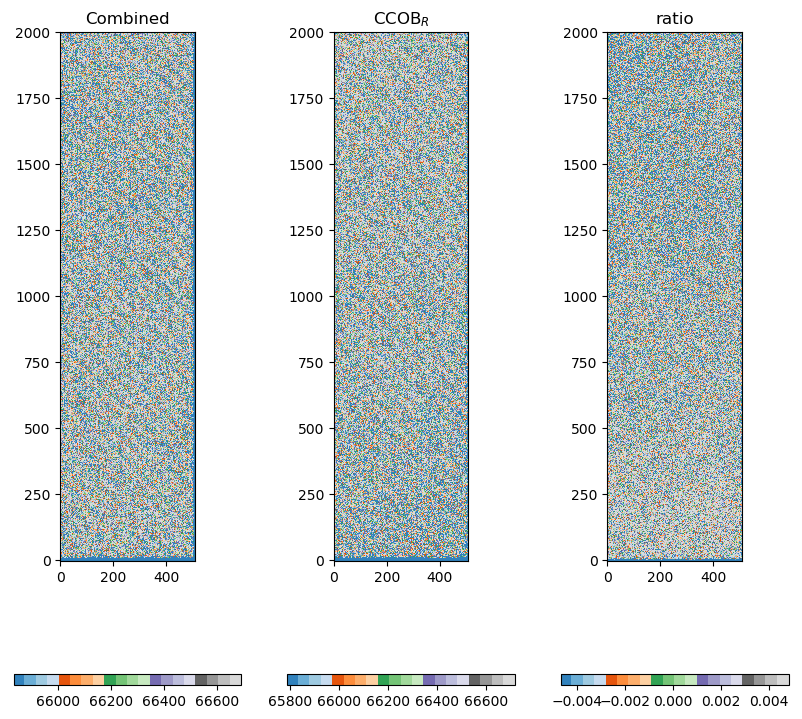

In [23]:
fig, axs = pylab.subplots(1,3,figsize=(10,10),dpi=100) 
for ax, animg, label in zip(axs,[normedimg, red, (normedimg-red)/red], ["Combined",r"CCOB$_{R}$","ratio"]):
    mean = numpy.median(animg)
    std = mad_std(animg)
    N = 1
    ax.set_title(label)
    im = ax.imshow(animg,vmin=mean-N*std,vmax=mean+N*std,origin="lower",cmap=pylab.get_cmap("tab20c"))
    fig.colorbar( im, ax=ax, orientation="horizontal")